# Subject Verb Agreement

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import font_manager as fm, pyplot as plt
import matplotlib as mpl
import wandb

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

### Preamble
Paths, colors, and WandB stuff

In [2]:
DATA_DIR = "../data/lgd_sva/"
MODEL_ID = "bf-google/bert_uncased_L-6_H-512_A-8"
# RESULTS_DIR = os.path.join(DATA_DIR, MODEL_ID, "results/max_grad/")
RESULTS_DIR = os.path.join(DATA_DIR, MODEL_ID, "results/max_grad/oplus")
AGG_MAX_GRAD_RESULTS_PATH = os.path.join(RESULTS_DIR, "agg_max_grad_results.csv")
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

In [3]:
# Plot formatting
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

try:
    # Set the font properties globally
    font_path = "./fonts/cmunbx.otf"
    font_prop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=font_prop.get_name())
except:
    print("Unable to set font to Computer Modern (cmunbx.otf)")

In [4]:
palette = sns.color_palette("colorblind", 5)
# palette = palette[:3] + palette[-1:]
# print([mpl.colors.to_hex(c) for c in palette])
# sns.set_palette(palette)
palette



[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844)]

In [5]:
palette = sns.color_palette("colorblind", 5)
palette = palette[:3] + palette[-1:]
print([mpl.colors.to_hex(c) for c in palette])
sns.set_palette(palette)
palette



['#0173b2', '#de8f05', '#029e73', '#cc78bc']


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8, 0.47058823529411764, 0.7372549019607844)]

In [6]:
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(
    os.getcwd(), "sva_max_grad.ipynb"
)
entity, PROJECT_NAME = "kdu", "bauer-kvq"  # set to your entity and project
config = {
    "MODEL_ID": MODEL_ID,
    "AGG_MAX_GRAD_RESULTS_PATH": AGG_MAX_GRAD_RESULTS_PATH,
    "palette": palette,
}
run = wandb.init(
    project=PROJECT_NAME,
    name=f"analyze_sva_max_grad_{datetime.now().isoformat(sep='_', timespec='seconds')}",
    tags=["analysis"],
    config=config,
    # mode="disabled", # if you want to disable all wandb logging
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: No data
wandb: ERROR Failed to sample metric: Not Supported


{'MODEL_ID': 'bf-google/bert_uncased_L-6_H-512_A-8', 'AGG_MAX_GRAD_RESULTS_PATH': '../data/lgd_sva/bf-google/bert_uncased_L-6_H-512_A-8/results/max_grad/oplus/agg_max_grad_results.csv', 'palette': [[0.00392156862745098, 0.45098039215686275, 0.6980392156862745], [0.8705882352941177, 0.5607843137254902, 0.0196078431372549], [0.00784313725490196, 0.6196078431372549, 0.45098039215686275], [0.8, 0.47058823529411764, 0.7372549019607844]]}


## Load Data

In [7]:
df = pd.read_csv(AGG_MAX_GRAD_RESULTS_PATH)
df['num_tokens'] = (df.groupby('sentence_index')['sentence_index'].transform('count') / len(df["layer_num"].unique()) / len(df["path_name"].unique())).astype(int)
df["path_name"].replace(
    to_replace={
        "matmul (bertselfattention key)": "Self-Attention Key",
        "matmul (bertselfattention mixed_query_layer)": "Self-Attention Query",
        "matmul (bertselfattention value)": "Self-Attention Value",
        "skip layer": "Skip Connection",
    },
    inplace=True
)
df = df.sort_values(["sentence_index", "token_index", "layer_num", "path_name"]).reset_index().drop(columns=["index"])
df


,sentence_index,is_correct,num_distractors,correct_word,correct_word_logit,incorrect_word,incorrect_word_logit,token,token_index,layer_num,path_name,path grad,masked_sentence,num_tokens
0,0,True,1,include,18.809654,includes,13.721537,[CLS],0,0,Self-Attention Key,0.044581,current areas of research ***mask*** novel aer...,41
1,0,True,1,include,18.809654,includes,13.721537,[CLS],0,0,Self-Attention Query,0.000000,current areas of research ***mask*** novel aer...,41
2,0,True,1,include,18.809654,includes,13.721537,[CLS],0,0,Self-Attention Value,0.000000,current areas of research ***mask*** novel aer...,41
3,0,True,1,include,18.809654,includes,13.721537,[CLS],0,0,Skip Connection,0.000000,current areas of research ***mask*** novel aer...,41
4,0,True,1,include,18.809654,includes,13.721537,[CLS],0,1,Self-Attention Key,0.069463,current areas of research ***mask*** novel aer...,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718483,999,True,1,include,13.359284,includes,8.602576,[SEP],27,4,Skip Connection,0.000000,"today , members of the movement ***mask*** als...",28
718484,999,True,1,include,13.359284,includes,8.602576,[SEP],27,5,Self-Attention Key,0.000000,"today , members of the movement ***mask*** als...",28
718485,999,True,1,include,13.359284,includes,8.602576,[SEP],27,5,Self-Attention Query,0.000000,"today , members of the movement ***mask*** als...",28
718486,999,True,1,include,13.359284,includes,8.602576,[SEP],27,5,Self-Attention Value,0.855136,"today , members of the movement ***mask*** als...",28


In [8]:
# Correctness sanity check
df.groupby("sentence_index")["is_correct"].agg("mean").value_counts()

1.0    956
0.0     44
Name: is_correct, dtype: int64

## Prepare Dataframe

In [9]:
df_no_mask_toks = df[df["token"] != "[MASK]"]
# df_analysis = df_no_mask_toks.groupby(['path_name', 'layer_num']).agg({"path grad": "mean"}) # {'entropy': 'mean', 'num_distractors': 'mean', 'num_tokens': 'mean', 'correct_word_logit': 'mean', 'incorrect_word_logit': 'mean'})
df_analysis = df.groupby(['path_name', 'layer_num']).agg({"path grad": "mean"}) # {'entropy': 'mean', 'num_distractors': 'mean', 'num_tokens': 'mean', 'correct_word_logit': 'mean', 'incorrect_word_logit': 'mean'})
table = wandb.Table(dataframe=df_analysis)
wandb.log({"path_grads_summary_all_words": table})
df_analysis



path grad
path_name            layer_num              
Self-Attention Key   0          1.849626e-02
                     1          8.146572e-03
                     2          6.695504e-03
                     3          2.070995e-02
                     4          1.892507e-02
                     5          3.553477e-02
Self-Attention Query 0          2.624334e-06
                     1          0.000000e+00
                     2          0.000000e+00
                     3          8.850275e-07
                     4          0.000000e+00
                     5          5.603989e-04
Self-Attention Value 0          4.027694e-03
                     1          2.438933e-03
                     2          2.187073e-03
                     3          7.520410e-03
                     4          2.015332e-02
                     5          3.603942e-02
Skip Connection      0          1.422860e-01
                     1          1.056374e-01
                     2          1.247036e-01
                     3          1.236203e-01
                     4          1.173381e-01
                     5          6.619421e-02

### Gradient split between K/V/Q and Skip layer for different layers 
(avg across all tokens, minus [MASK])

Text(0.5, 1.0, "Gradient flow through keys, values, and queries avg'd on all tokens of the sentence, per layer")

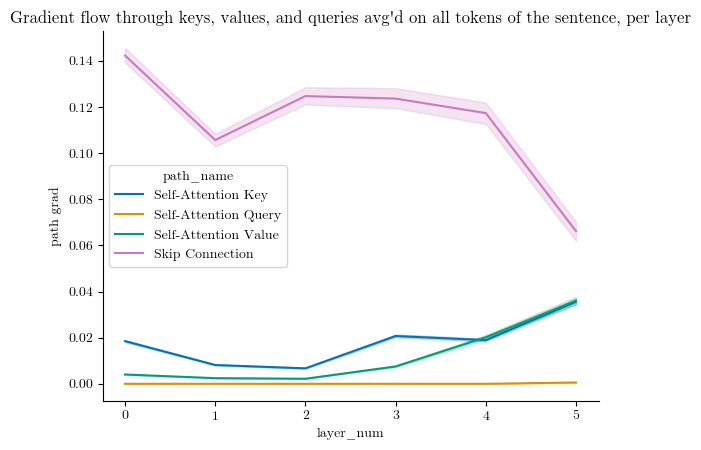

In [10]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="layer_num", y="path grad", hue="path_name", ax=ax)
ax.set_title("Gradient flow through keys, values, and queries avg'd on all tokens of the sentence, per layer", wrap=True)

### Gradient split specifically for subject and distractor tokens

In [11]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("google/bert_uncased_L-6_H-128_A-2")
def convert_sentence_to_tokens_and_target_idx(sent: str, tokenizer):
    pre, target, post = sent.split("***")
    if "mask" in target.lower():
        target = ["[MASK]"]
    else:
        target = tokenizer.tokenize(target)
    tokens = ["[CLS]"] + tokenizer.tokenize(pre)
    target_idx = len(tokens)
    # print(target_idx)
    tokens += target + tokenizer.tokenize(post) + ["[SEP]"]
    return tokens, target_idx

len(convert_sentence_to_tokens_and_target_idx("current areas of research ***mask*** novel aerospace materials , performance analysis systems for automobiles , hydrofoil ships , deep-diving vessels for oceanographic research , high-speed rail-type systems and several others .", tokenizer)[0])

/home/kevin/miniconda3/envs/jax-hf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


41

In [12]:
NOUN_POS_PATH = os.path.join(DATA_DIR, "max_grad_data_noun_indices.jsonl")
noun_pos_df = pd.read_json(NOUN_POS_PATH, lines=True, orient="records")
noun_pos_df

,sentence_index,sentence,correct_word,subj,intervening_distractors,preceding_distractors,tokens,intervening_distractors_idx,preceding_distractors_idx,subj_idx
0,0,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
1,1,other novels that mention the magazine include...,include,novels,"[that, magazine]","[that, magazine]","[[CLS], other, novels, that, mention, the, mag...","[3, 6]","[3, 6]",[2]
2,2,the composition of such particles depends on t...,depends,composition,[particles],[particles],"[[CLS], the, composition, of, such, particles,...",[5],[5],[2]
3,3,it was eventually revealed that the challenge ...,depends,level,[tasks],"[it, challenge, tasks]","[[CLS], it, was, eventually, revealed, that, t...",[11],"[1, 7, 11]",[8]
4,4,the notable areas within this region include c...,include,areas,[region],[region],"[[CLS], the, notable, areas, within, this, reg...",[6],[6],[3]
...,...,...,...,...,...,...,...,...,...,...
666,995,"in addition , areas in texas that are slightly...",see,areas,"[texas, that, gulf, mexico, austin, san, anton...","[addition, texas, that, gulf, mexico, austin, ...","[[CLS], in, addition, ,, areas, in, texas, tha...","[6, 7, 13, 15, 19, 21, 22, 7, 29, 30]","[2, 6, 7, 13, 15, 19, 21, 22, 7, 29, 30]",[4]
667,996,"in the united states , leaders of this movemen...",include,leaders,[movement],"[united, states, movement]","[[CLS], in, the, united, states, ,, leaders, o...",[9],"[3, 4, 9]",[6]
668,997,arguments that reference policy carry more wei...,carry,policy,[],"[arguments, reference]","[[CLS], arguments, that, reference, policy, [M...",[],"[1, 3]",[4]
669,998,sporting clubs in the area include wilston nor...,include,clubs,[area],"[sporting, area]","[[CLS], sporting, clubs, in, the, area, [MASK]...",[5],"[1, 5]",[2]


In [13]:
# COMMENTING OUT FOR RUNTIME SPEED
# ### Sanity check bc token num diff
# for i in range(len(noun_pos_df)):
#     sentence_idx = noun_pos_df["sentence_index"].iloc[i]
#     toks = noun_pos_df["tokens"].iloc[i]
#     subj = noun_pos_df["subj"].iloc[i]
#     subj_idx = noun_pos_df["subj_idx"].iloc[i][0]

#     # Verify that the token index of subj matches the subj word in the spacy parsed sentence
#     assert toks[subj_idx] == subj
#     d_idxs = noun_pos_df["preceding_distractors_idx"].iloc[i]
#     ds = noun_pos_df["preceding_distractors"].iloc[i]

#     # Verify that the token index of each distractor matches the distractor word in the spacy parsed sentence
#     for i in range(len(ds)):
#         assert(toks[d_idxs[i]] == ds[i])

#     # Verify that the token index of subj matches the subj word in the original parsed sentence
#     df[(df["sentence_index"] == sentence_idx) & (df["token_index"] == subj_idx) & (df["layer_num"] == 0) & (df["path_name"] == "skip layer")]["token"].item() == subj

#     # Verify that the token index of each distractor matches the distractor word in the original parsed sentence
#     for i in range(len(ds)):
#         assert df[(df["sentence_index"] == sentence_idx) & (df["token_index"] == d_idxs[i]) & (df["layer_num"] == 0) & (df["path_name"] == "skip layer")]["token"].item() == ds[i], (df[(df["sentence_index"] == sentence_idx) & (df["token_index"] == d_idxs[i]) & (df["layer_num"] == 0) & (df["path_name"] == "skip layer")]["token"].item(), d_idxs[i], ds[i], sentence_idx)




In [14]:
df_with_noun_pos = df.merge(noun_pos_df, on=["sentence_index"], how="right").dropna()#.sort_values(["sentence_index", "token_index", "layer_num", "path_name"]).reset_index().drop(columns=["index"])
df_with_noun_pos.head()

,sentence_index,is_correct,num_distractors,correct_word_x,correct_word_logit,incorrect_word,incorrect_word_logit,token,token_index,layer_num,...,num_tokens,sentence,correct_word_y,subj,intervening_distractors,preceding_distractors,tokens,intervening_distractors_idx,preceding_distractors_idx,subj_idx
0,0,True,1,include,18.809654,includes,13.721537,[CLS],0,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
1,0,True,1,include,18.809654,includes,13.721537,[CLS],0,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
2,0,True,1,include,18.809654,includes,13.721537,[CLS],0,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
3,0,True,1,include,18.809654,includes,13.721537,[CLS],0,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
4,0,True,1,include,18.809654,includes,13.721537,[CLS],0,1,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]


In [15]:
df_only_subj = df_with_noun_pos[df_with_noun_pos.apply(lambda x: x["token_index"] == x["subj_idx"][0], axis=1)]
df_only_subj

,sentence_index,is_correct,num_distractors,correct_word_x,correct_word_logit,incorrect_word,incorrect_word_logit,token,token_index,layer_num,...,num_tokens,sentence,correct_word_y,subj,intervening_distractors,preceding_distractors,tokens,intervening_distractors_idx,preceding_distractors_idx,subj_idx
48,0,True,1,include,18.809654,includes,13.721537,areas,2,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
49,0,True,1,include,18.809654,includes,13.721537,areas,2,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
50,0,True,1,include,18.809654,includes,13.721537,areas,2,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
51,0,True,1,include,18.809654,includes,13.721537,areas,2,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
52,0,True,1,include,18.809654,includes,13.721537,areas,2,1,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462931,999,True,1,include,13.359284,includes,8.602576,members,3,4,...,28,"today , members of the movement include also m...",include,members,[movement],"[today, movement]","[[CLS], today, ,, members, of, the, movement, ...",[6],"[1, 6]",[3]
462932,999,True,1,include,13.359284,includes,8.602576,members,3,5,...,28,"today , members of the movement include also m...",include,members,[movement],"[today, movement]","[[CLS], today, ,, members, of, the, movement, ...",[6],"[1, 6]",[3]
462933,999,True,1,include,13.359284,includes,8.602576,members,3,5,...,28,"today , members of the movement include also m...",include,members,[movement],"[today, movement]","[[CLS], today, ,, members, of, the, movement, ...",[6],"[1, 6]",[3]
462934,999,True,1,include,13.359284,includes,8.602576,members,3,5,...,28,"today , members of the movement include also m...",include,members,[movement],"[today, movement]","[[CLS], today, ,, members, of, the, movement, ...",[6],"[1, 6]",[3]


In [16]:
df_only_subj_analysis = df_only_subj.groupby(['path_name', 'layer_num']).agg({"path grad": "mean"}) # {'entropy': 'mean', 'num_distractors': 'mean', 'num_tokens': 'mean', 'correct_word_logit': 'mean', 'incorrect_word_logit': 'mean'})
table = wandb.Table(dataframe=df_only_subj_analysis)
wandb.log({"path_grads_summary_only_subj": table})
df_only_subj_analysis


path grad
path_name            layer_num           
Self-Attention Key   0           0.019546
                     1           0.000648
                     2           0.001382
                     3           0.013959
                     4           0.080041
                     5           0.114460
Self-Attention Query 0           0.000000
                     1           0.000000
                     2           0.000000
                     3           0.000000
                     4           0.000000
                     5           0.000000
Self-Attention Value 0           0.000000
                     1           0.000024
                     2           0.000015
                     3           0.000299
                     4           0.008548
                     5           0.035945
Skip Connection      0           0.298683
                     1           0.205193
                     2           0.211378
                     3           0.211426
                     4           0.130506
                     5           0.000000

In [17]:
df_only_subj_analysis_normal_df = df_only_subj_analysis.reset_index()
df_only_subj_last_layer_path_grads = df_only_subj_analysis_normal_df[df_only_subj_analysis_normal_df["layer_num"] == 5]
df_only_subj_last_layer_path_grads["% path grad"] = df_only_subj_last_layer_path_grads["path grad"]/df_only_subj_last_layer_path_grads["path grad"].sum()
percent_keys = df_only_subj_last_layer_path_grads[df_only_subj_last_layer_path_grads["path_name"] == "Self-Attention Key"]["% path grad"].item()
print(f'Percent of gradient flow through keys in last layer: {percent_keys * 100:.2f}%')
df_only_subj_last_layer_path_grads

Percent of gradient flow through keys in last layer: 76.10%


/tmp/ipykernel_210847/3396617752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_subj_last_layer_path_grads["% path grad"] = df_only_subj_last_layer_path_grads["path grad"]/df_only_subj_last_layer_path_grads["path grad"].sum()


,path_name,layer_num,path grad,% path grad
5,Self-Attention Key,5,0.114460,0.76101
11,Self-Attention Query,5,0.000000,0.00000
17,Self-Attention Value,5,0.035945,0.23899
23,Skip Connection,5,0.000000,0.00000


Text(0.5, 1.0, 'Gradient flow through keys, values, and queries for the SUBJECT of the sentence, per layer')

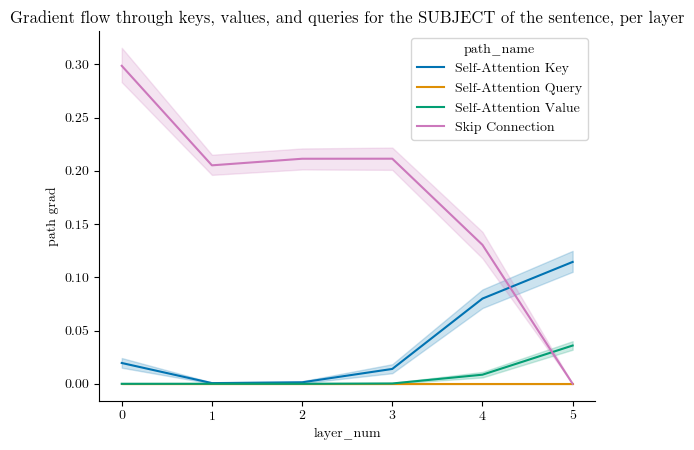

In [18]:
fig, ax = plt.subplots()
sns.lineplot(data=df_only_subj, x="layer_num", y="path grad", hue="path_name", ax=ax)
ax.set_title("Gradient flow through keys, values, and queries for the SUBJECT of the sentence, per layer", wrap=True)

### KVQ/Skip Gradient flow for Preceding Distractors

In [19]:
df_only_distractors = df_with_noun_pos[df_with_noun_pos.apply(lambda x: x["token_index"] in x["preceding_distractors_idx"], axis=1)]
df_only_distractors

,sentence_index,is_correct,num_distractors,correct_word_x,correct_word_logit,incorrect_word,incorrect_word_logit,token,token_index,layer_num,...,num_tokens,sentence,correct_word_y,subj,intervening_distractors,preceding_distractors,tokens,intervening_distractors_idx,preceding_distractors_idx,subj_idx
96,0,True,1,include,18.809654,includes,13.721537,research,4,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
97,0,True,1,include,18.809654,includes,13.721537,research,4,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
98,0,True,1,include,18.809654,includes,13.721537,research,4,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
99,0,True,1,include,18.809654,includes,13.721537,research,4,0,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
100,0,True,1,include,18.809654,includes,13.721537,research,4,1,...,41,current areas of research include novel aerosp...,include,areas,[research],[research],"[[CLS], current, areas, of, research, [MASK], ...",[4],[4],[2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463003,999,True,1,include,13.359284,includes,8.602576,movement,6,4,...,28,"today , members of the movement include also m...",include,members,[movement],"[today, movement]","[[CLS], today, ,, members, of, the, movement, ...",[6],"[1, 6]",[3]
463004,999,True,1,include,13.359284,includes,8.602576,movement,6,5,...,28,"today , members of the movement include also m...",include,members,[movement],"[today, movement]","[[CLS], today, ,, members, of, the, movement, ...",[6],"[1, 6]",[3]
463005,999,True,1,include,13.359284,includes,8.602576,movement,6,5,...,28,"today , members of the movement include also m...",include,members,[movement],"[today, movement]","[[CLS], today, ,, members, of, the, movement, ...",[6],"[1, 6]",[3]
463006,999,True,1,include,13.359284,includes,8.602576,movement,6,5,...,28,"today , members of the movement include also m...",include,members,[movement],"[today, movement]","[[CLS], today, ,, members, of, the, movement, ...",[6],"[1, 6]",[3]


In [20]:
df_only_distractors_analysis = df_only_distractors.groupby(['path_name', 'layer_num']).agg({"path grad": "mean"}) # {'entropy': 'mean', 'num_distractors': 'mean', 'num_tokens': 'mean', 'correct_word_logit': 'mean', 'incorrect_word_logit': 'mean'})
table = wandb.Table(dataframe=df_only_distractors_analysis)
wandb.log({"path_grads_summary_only_preceding_distractors": table})
df_only_distractors_analysis

path grad
path_name            layer_num           
Self-Attention Key   0           0.031410
                     1           0.005282
                     2           0.010691
                     3           0.089886
                     4           0.009916
                     5           0.038518
Self-Attention Query 0           0.000000
                     1           0.000000
                     2           0.000000
                     3           0.000000
                     4           0.000000
                     5           0.000000
Self-Attention Value 0           0.001246
                     1           0.000465
                     2           0.001048
                     3           0.004752
                     4           0.003941
                     5           0.018709
Skip Connection      0           0.190123
                     1           0.128468
                     2           0.119128
                     3           0.034480
                     4           0.057964
                     5           0.000000

Text(0.5, 1.0, 'Gradient flow through keys, values, and queries for the PRECEDING DISTRACTORS of the sentence, per layer')

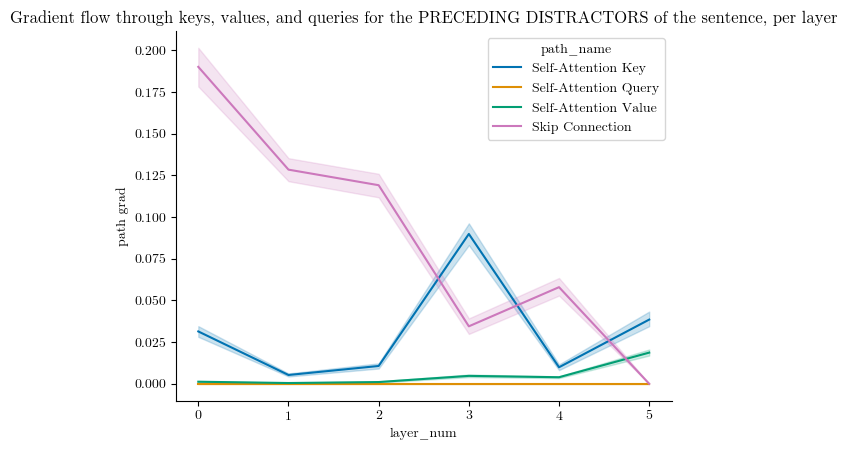

In [21]:
fig, ax = plt.subplots()
sns.lineplot(data=df_only_distractors, x="layer_num", y="path grad", hue="path_name", ax=ax)
ax.set_title("Gradient flow through keys, values, and queries for the PRECEDING DISTRACTORS of the sentence, per layer", wrap=True)

### KVQ/Skip Gradient flow for Preceding Distractors

Text(0.5, 1.0, 'Gradient flow through keys, values, and queries for the INTERVENING DISTRACTORS of the sentence, per layer')

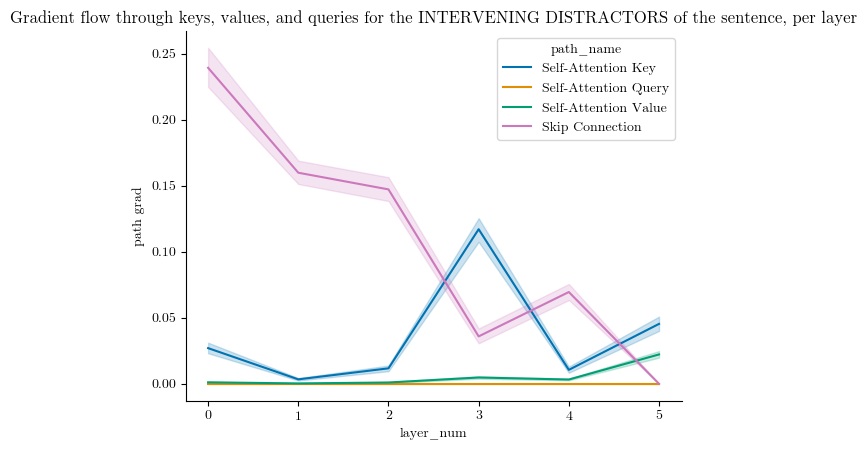

In [22]:
df_only_i_distractors = df_with_noun_pos[df_with_noun_pos.apply(lambda x: x["token_index"] in x["intervening_distractors_idx"], axis=1)]
df_only_i_distractors_analysis = df_only_i_distractors.groupby(['path_name', 'layer_num']).agg({"path grad": "mean"}) # {'entropy': 'mean', 'num_distractors': 'mean', 'num_tokens': 'mean', 'correct_word_logit': 'mean', 'incorrect_word_logit': 'mean'})
table = wandb.Table(dataframe=df_only_i_distractors_analysis)
wandb.log({"path_grads_summary_only_intervening_distractors": table})
fig, ax = plt.subplots()
sns.lineplot(data=df_only_i_distractors, x="layer_num", y="path grad", hue="path_name", ax=ax)
ax.set_title("Gradient flow through keys, values, and queries for the INTERVENING DISTRACTORS of the sentence, per layer", wrap=True)

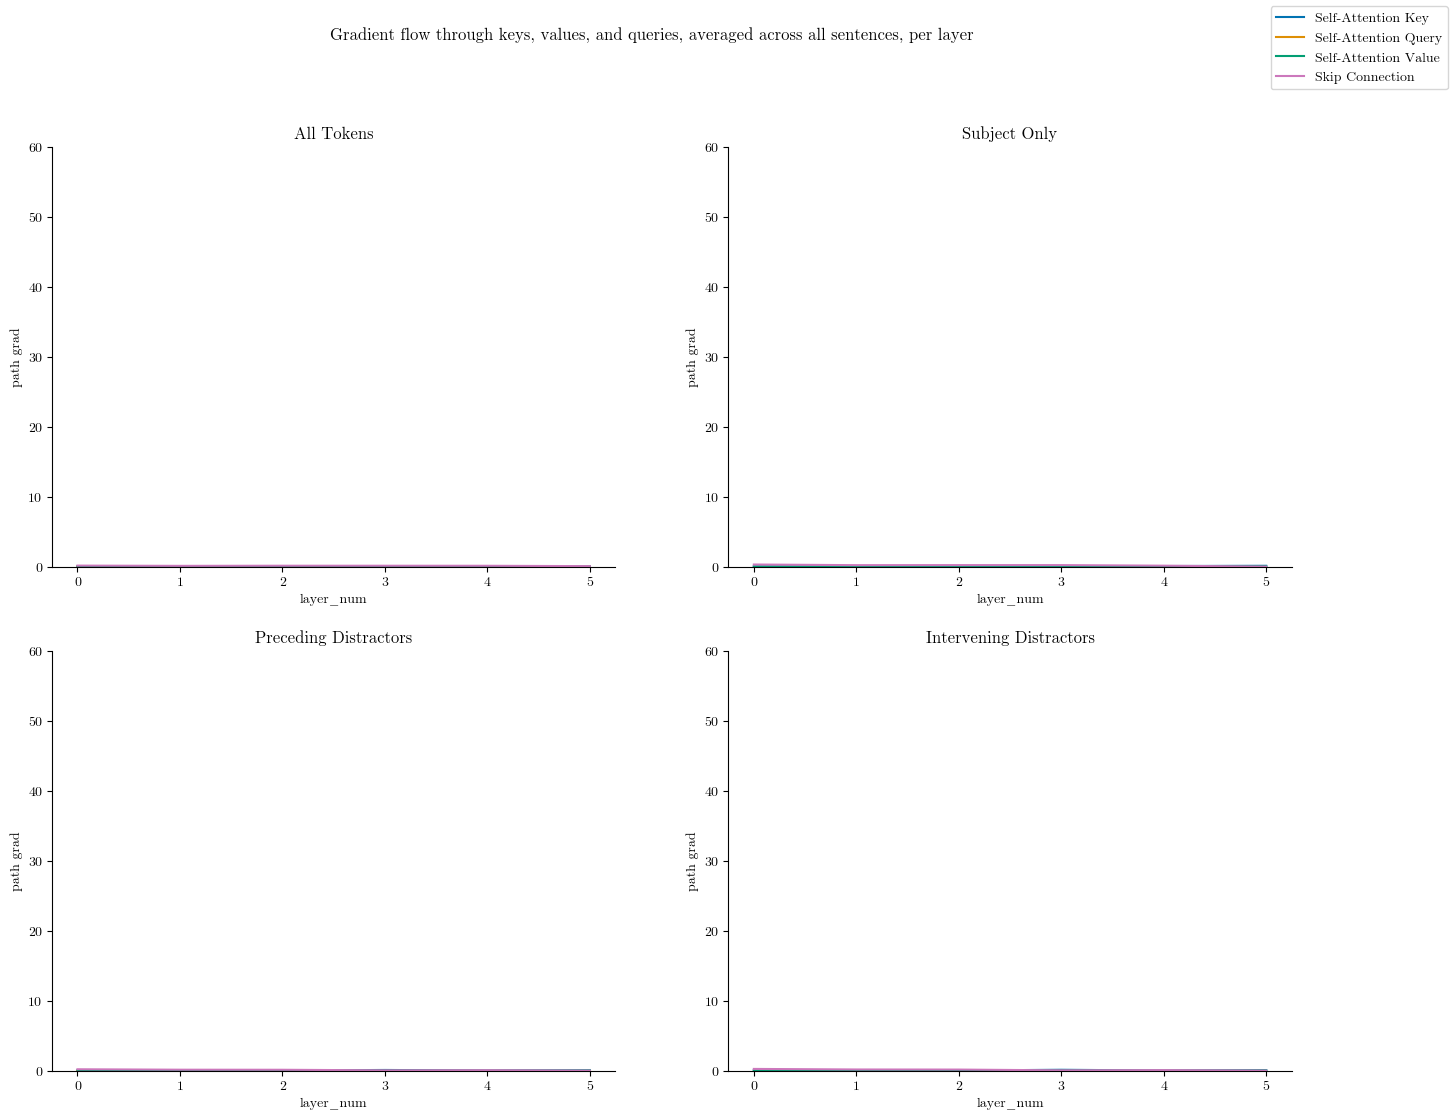

In [23]:
dfs = [df, df_only_subj, df_only_distractors, df_only_i_distractors]
titles = ["All Tokens", "Subject Only", "Preceding Distractors", "Intervening Distractors"]
ncols = 2
nrows = int(np.ceil(len(dfs) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12))
# plt.tight_layout()
for i in range(len(dfs)):
    use_legend = (i == len(dfs) - 1)
    row, col = i // nrows, i % nrows
    ax = axes[row, col]
    sns.lineplot(data=dfs[i], x="layer_num", y="path grad", hue="path_name", ax=ax, legend=use_legend)
    ax.set_ylim((0, 60))
    ax.set_title(titles[i], wrap=True)
fig.suptitle("Gradient flow through keys, values, and queries, averaged across all sentences, per layer")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
ax.get_legend().remove()

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8, 0.47058823529411764, 0.7372549019607844)]


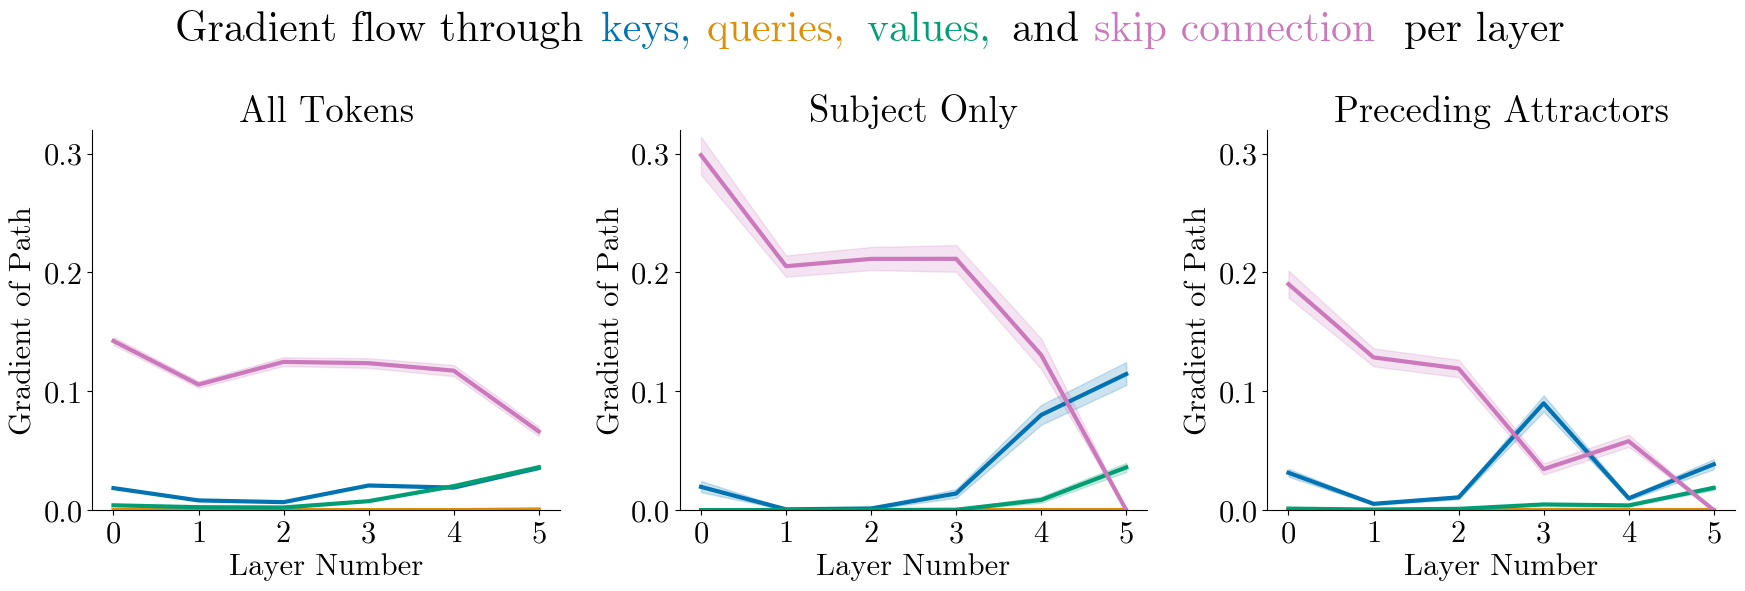

In [24]:
plt.rc('font', size=22)
dfs = [df, df_only_subj, df_only_distractors]
titles = ["All Tokens", "Subject Only", "Preceding Attractors"]
ncols = 3
nrows = int(np.ceil(len(dfs) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 6))
# plt.tight_layout()
for i in range(len(dfs)):
    use_legend = False # (i == len(dfs) - 1)
    row, col = i // ncols, i % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    sns.lineplot(
        data=dfs[i], 
        x="layer_num", 
        y="path grad", 
        hue="path_name", 
        # style="is_correct",
        ax=ax,
        legend=use_legend,
        linewidth=3,
    )
    ax.set_ylim((0, 0.32))
    ax.set_title(titles[i], wrap=True)
    ax.set_xlabel("Layer Number")
    ax.set_ylabel("Gradient of Path")
    ax.set_xticks(ticks=sorted(dfs[i]["layer_num"].unique()))
linecolors = [l.get_color() for l in ax.get_lines()]
print(linecolors)
# Lolmao you can't make a title have different colors in it so...manual labor it is l o l.
plt.rc('font', size=25)
offset = 0.23
fig.text(0. + offset, 0.95, "Gradient flow through ", ha="center", va="bottom", size="large", color="black")
fig.text(0.148 + offset, 0.95, "keys, ", ha="center", va="bottom", size="large", color=linecolors[0])
fig.text(0.22 + offset, 0.95, "queries, ", ha="center", va="bottom", size="large", color=linecolors[1])
fig.text(0.305 + offset, 0.95, "values, ", ha="center", va="bottom", size="large", color=linecolors[2])
fig.text(0.37 + offset, 0.95, "and ", ha="center", va="bottom", size="large", color="black")
fig.text(0.475 + offset, 0.95, "skip connection ", ha="center", va="bottom", size="large", color=linecolors[3])
fig.text(0.61 + offset, 0.95, "per layer", ha="center", va="bottom", size="large", color="black")
# fig.text(0.24 + offset, 0.60, "GOOD BERT", ha="center", va="bottom", size="large", color="red")

# fig.suptitle("Gradient flow through keys, values, queries, and skip connection per layer", wrap=True)
fig.suptitle("")

# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc="right")
# ax.get_legend().remove()
plt.tight_layout()
save_path = os.path.join(PLOTS_DIR, "max_grad_kvqskip_tokens_subj_and_preceding_distractors.png")
save_path_pdf = os.path.join(PLOTS_DIR, "max_grad_kvqskip_tokens_subj_and_preceding_distractors.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.savefig(save_path_pdf, bbox_inches="tight")
wandb.log({"plot_max_grad_kvqskip_tokens_subj_and_preceding_distractors": wandb.Image(save_path)})

path_name             layer_num
Self-Attention Key    0               0
                      1               0
                      2               0
                      3               0
                      4               0
                      5               0
Self-Attention Query  0               0
                      1               0
                      2               0
                      3               0
                      4               0
                      5               8
Self-Attention Value  0               0
                      1               0
                      2               0
                      3               0
                      4               0
                      5               0
Skip Connection       0            1000
                      1            1000
                      2            1000
                      3            1000
                      4            1000
                      5             992
Name: pa

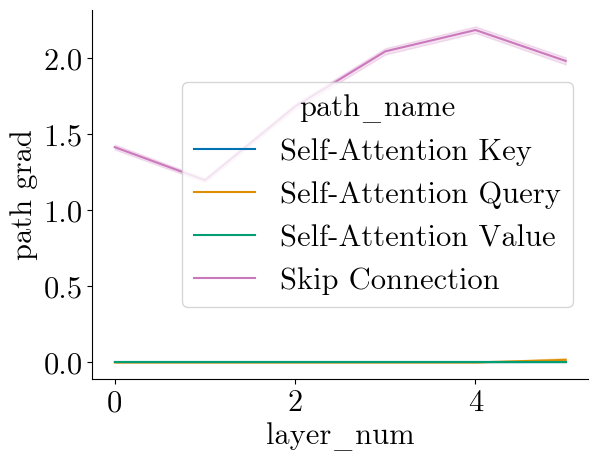

In [26]:
df_only_mask = df[df["token"] == "[MASK]"]

fig, ax = plt.subplots()
sns.lineplot(
    data=df_only_mask, 
    x="layer_num", 
    y="path grad", 
    hue="path_name", 
    ax=ax,
    legend=True,
    # linewidth=3,
)
# df_only_mask.head(25)
max_grad_per_path_layer_sentence_df = pd.DataFrame(df_only_mask.groupby(["path_name", "layer_num", "sentence_index"])["path grad"].agg("max"))
# Group the DataFrame by 'path_name', 'layer_num'
grouped = max_grad_per_path_layer_sentence_df.groupby(['path_name', 'layer_num'])

# Count the non-zero values for each group
nonzero_counts = grouped['path grad'].apply(lambda x: (x != 0).sum())
nonzero_counts

In [27]:
# Find the maximum 'path grad' for each combination of 'path_name' and 'layer_num'
max_pathgrads = df_only_mask.groupby(['path_name', 'layer_num'])['path grad'].max()

# Count the number of sentences with the highest 'path grad' for each combination of 'path_name' and 'layer_num'
sentence_counts = df_only_mask[df_only_mask['path grad'].isin(max_pathgrads)].groupby(['path_name', 'layer_num']).size()

print(sentence_counts)

path_name             layer_num
Self-Attention Key    0            1000
                      1            1000
                      2            1000
                      3            1000
                      4            1000
                      5            1000
Self-Attention Query  0            1000
                      1            1000
                      2            1000
                      3            1000
                      4            1000
                      5             993
Self-Attention Value  0            1000
                      1            1000
                      2            1000
                      3            1000
                      4            1000
                      5            1000
Skip Connection       0               1
                      1               1
                      2               1
                      3               1
                      4               1
                      5               9
dtype: i

### Compare path grads for correct and incorrect examples

In [28]:
correct_only_df = df[df["is_correct"]]
correct_only_df_only_subj = df_only_subj[df_only_subj["is_correct"]]
correct_only_df_only_distractors = df_only_distractors[df_only_distractors["is_correct"]]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8, 0.47058823529411764, 0.7372549019607844)]


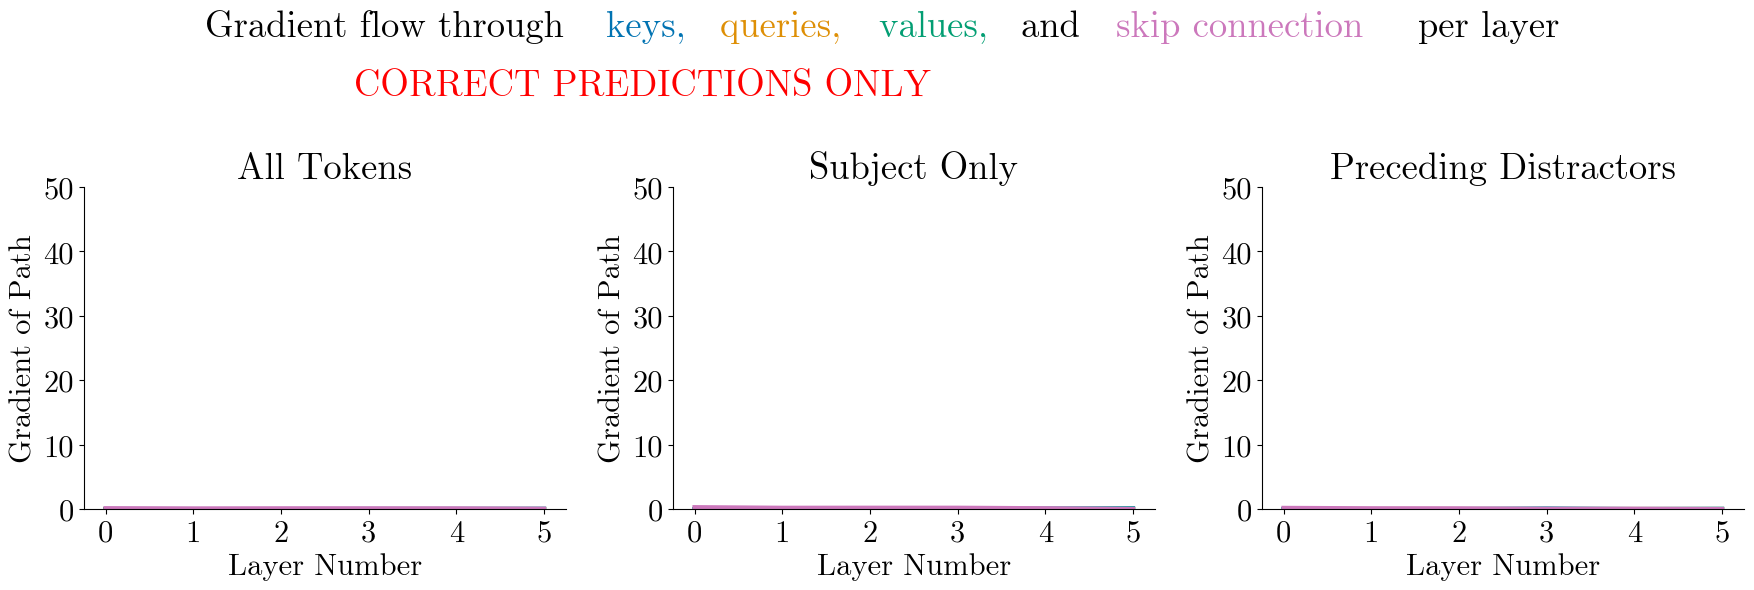

In [29]:
dfs = [correct_only_df, correct_only_df_only_subj, correct_only_df_only_distractors]
titles = ["All Tokens", "Subject Only", "Preceding Distractors"]
ncols = 3
nrows = int(np.ceil(len(dfs) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 6))
# plt.tight_layout()
for i in range(len(dfs)):
    use_legend = False # (i == len(dfs) - 1)
    row, col = i // ncols, i % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    sns.lineplot(
        data=dfs[i], 
        x="layer_num", 
        y="path grad",
        hue="path_name", 
        ax=ax,
        legend=use_legend,
        linewidth=3,
    )
    ax.set_ylim((0, 50))
    ax.set_title(titles[i], wrap=True)
    ax.set_xlabel("Layer Number")
    ax.set_ylabel("Gradient of Path")
    ax.set_xticks(ticks=sorted(dfs[i]["layer_num"].unique()))
linecolors = [l.get_color() for l in ax.get_lines()]
print(linecolors)
# Lolmao you can't make a title have different colors in it so...manual labor it is l o l.
offset = 0.23
fig.text(0. + offset, 0.95, "Gradient flow through ", ha="center", va="bottom", size="large", color="black")
fig.text(0.145 + offset, 0.95, "keys, ", ha="center", va="bottom", size="large", color=linecolors[0])
fig.text(0.22 + offset, 0.95, "queries, ", ha="center", va="bottom", size="large", color=linecolors[1])
fig.text(0.305 + offset, 0.95, "values, ", ha="center", va="bottom", size="large", color=linecolors[2])
fig.text(0.37 + offset, 0.95, "and ", ha="center", va="bottom", size="large", color="black")
fig.text(0.475 + offset, 0.95, "skip connection ", ha="center", va="bottom", size="large", color=linecolors[3])
fig.text(0.61 + offset, 0.95, "per layer", ha="center", va="bottom", size="large", color="black")
fig.text(0.14 + offset, 0.85, "CORRECT PREDICTIONS ONLY", ha="center", va="bottom", size="large", color="red")

# fig.suptitle("Gradient flow through keys, values, queries, and skip connection per layer", wrap=True)
fig.suptitle("\n")

# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc="right")
# ax.get_legend().remove()
plt.tight_layout()
save_path = os.path.join(PLOTS_DIR, "max_grad_kvqskip_tokens_subj_and_preceding_distractors_correct_only.png")
save_path_pdf = os.path.join(PLOTS_DIR, "max_grad_kvqskip_tokens_subj_and_preceding_distractors_correct_only.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.savefig(save_path_pdf, bbox_inches="tight")
wandb.log({"plot_max_grad_kvqskip_tokens_subj_and_preceding_distractors_correct_only": wandb.Image(save_path)})

In [30]:
incorrect_only_df = df[df["is_correct"] == False]
incorrect_only_df_only_subj = df_only_subj[df_only_subj["is_correct"] == False]
incorrect_only_df_only_distractors = df_only_distractors[df_only_distractors["is_correct"] == False]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8, 0.47058823529411764, 0.7372549019607844)]


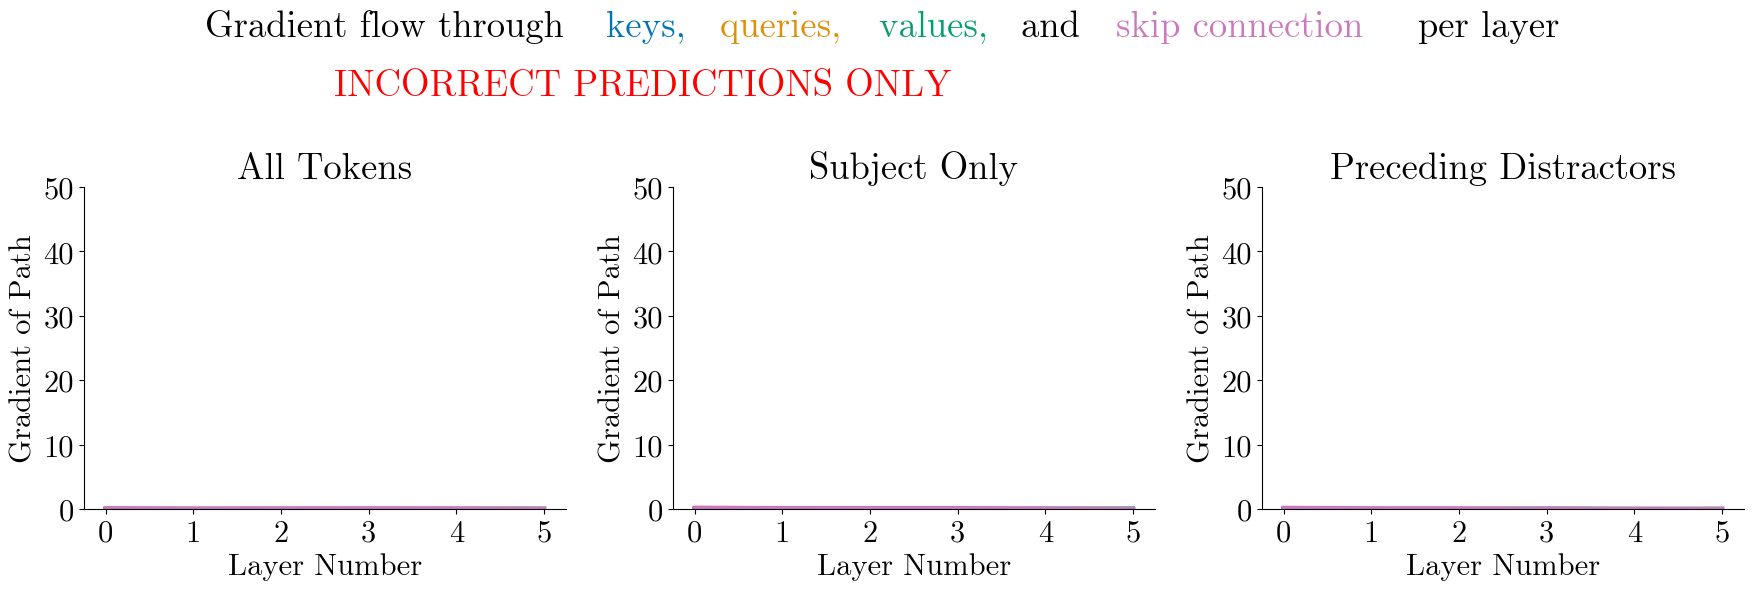

In [31]:
dfs = [incorrect_only_df, incorrect_only_df_only_subj, incorrect_only_df_only_distractors]
titles = ["All Tokens", "Subject Only", "Preceding Distractors"]
ncols = 3
nrows = int(np.ceil(len(dfs) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 6))
# plt.tight_layout()
for i in range(len(dfs)):
    use_legend = False # (i == len(dfs) - 1)
    row, col = i // ncols, i % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    sns.lineplot(
        data=dfs[i], 
        x="layer_num", 
        y="path grad", 
        hue="path_name", 
        ax=ax,
        legend=use_legend,
        linewidth=3,
    )
    ax.set_ylim((0, 50))
    ax.set_title(titles[i], wrap=True)
    ax.set_xlabel("Layer Number")
    ax.set_ylabel("Gradient of Path")
    ax.set_xticks(ticks=sorted(dfs[i]["layer_num"].unique()))
linecolors = [l.get_color() for l in ax.get_lines()]
print(linecolors)
# Lolmao you can't make a title have different colors in it so...manual labor it is l o l.
offset = 0.23
fig.text(0. + offset, 0.95, "Gradient flow through ", ha="center", va="bottom", size="large", color="black")
fig.text(0.145 + offset, 0.95, "keys, ", ha="center", va="bottom", size="large", color=linecolors[0])
fig.text(0.22 + offset, 0.95, "queries, ", ha="center", va="bottom", size="large", color=linecolors[1])
fig.text(0.305 + offset, 0.95, "values, ", ha="center", va="bottom", size="large", color=linecolors[2])
fig.text(0.37 + offset, 0.95, "and ", ha="center", va="bottom", size="large", color="black")
fig.text(0.475 + offset, 0.95, "skip connection ", ha="center", va="bottom", size="large", color=linecolors[3])
fig.text(0.61 + offset, 0.95, "per layer", ha="center", va="bottom", size="large", color="black")
fig.text(0.14 + offset, 0.85, "INCORRECT PREDICTIONS ONLY", ha="center", va="bottom", size="large", color="red")

# fig.suptitle("Gradient flow through keys, values, queries, and skip connection per layer", wrap=True)
fig.suptitle("\n")

# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc="right")
# ax.get_legend().remove()
plt.tight_layout()
save_path = os.path.join(PLOTS_DIR, "max_grad_kvqskip_tokens_subj_and_preceding_distractors_incorrect_only.png")
save_path_pdf = os.path.join(PLOTS_DIR, "max_grad_kvqskip_tokens_subj_and_preceding_distractors_incorrect_only.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.savefig(save_path_pdf, bbox_inches="tight")
wandb.log({"plot_max_grad_kvqskip_tokens_subj_and_preceding_distractors_incorrect_only": wandb.Image(save_path)})

In [32]:
dfs = [df, df_only_subj, df_only_distractors]
[[d[d["num_distractors"] == i] for d in dfs] for i in range(1, 5)][1][0]

,sentence_index,is_correct,num_distractors,correct_word,correct_word_logit,incorrect_word,incorrect_word_logit,token,token_index,layer_num,path_name,path grad,masked_sentence,num_tokens
7032,9,True,2,appear,12.388001,appears,9.351329,[CLS],0,0,Self-Attention Key,0.000000,the oldest uses of the term jackshaft ***mask*...,33
7033,9,True,2,appear,12.388001,appears,9.351329,[CLS],0,0,Self-Attention Query,0.000000,the oldest uses of the term jackshaft ***mask*...,33
7034,9,True,2,appear,12.388001,appears,9.351329,[CLS],0,0,Self-Attention Value,0.000000,the oldest uses of the term jackshaft ***mask*...,33
7035,9,True,2,appear,12.388001,appears,9.351329,[CLS],0,0,Skip Connection,0.087901,the oldest uses of the term jackshaft ***mask*...,33
7036,9,True,2,appear,12.388001,appears,9.351329,[CLS],0,1,Self-Attention Key,0.156304,the oldest uses of the term jackshaft ***mask*...,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715939,995,True,2,see,9.043229,sees,7.803140,[SEP],56,4,Skip Connection,0.923381,"in addition , areas in texas that are slightly...",57
715940,995,True,2,see,9.043229,sees,7.803140,[SEP],56,5,Self-Attention Key,1.095315,"in addition , areas in texas that are slightly...",57
715941,995,True,2,see,9.043229,sees,7.803140,[SEP],56,5,Self-Attention Query,0.000000,"in addition , areas in texas that are slightly...",57
715942,995,True,2,see,9.043229,sees,7.803140,[SEP],56,5,Self-Attention Value,0.000000,"in addition , areas in texas that are slightly...",57


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8, 0.47058823529411764, 0.7372549019607844)]


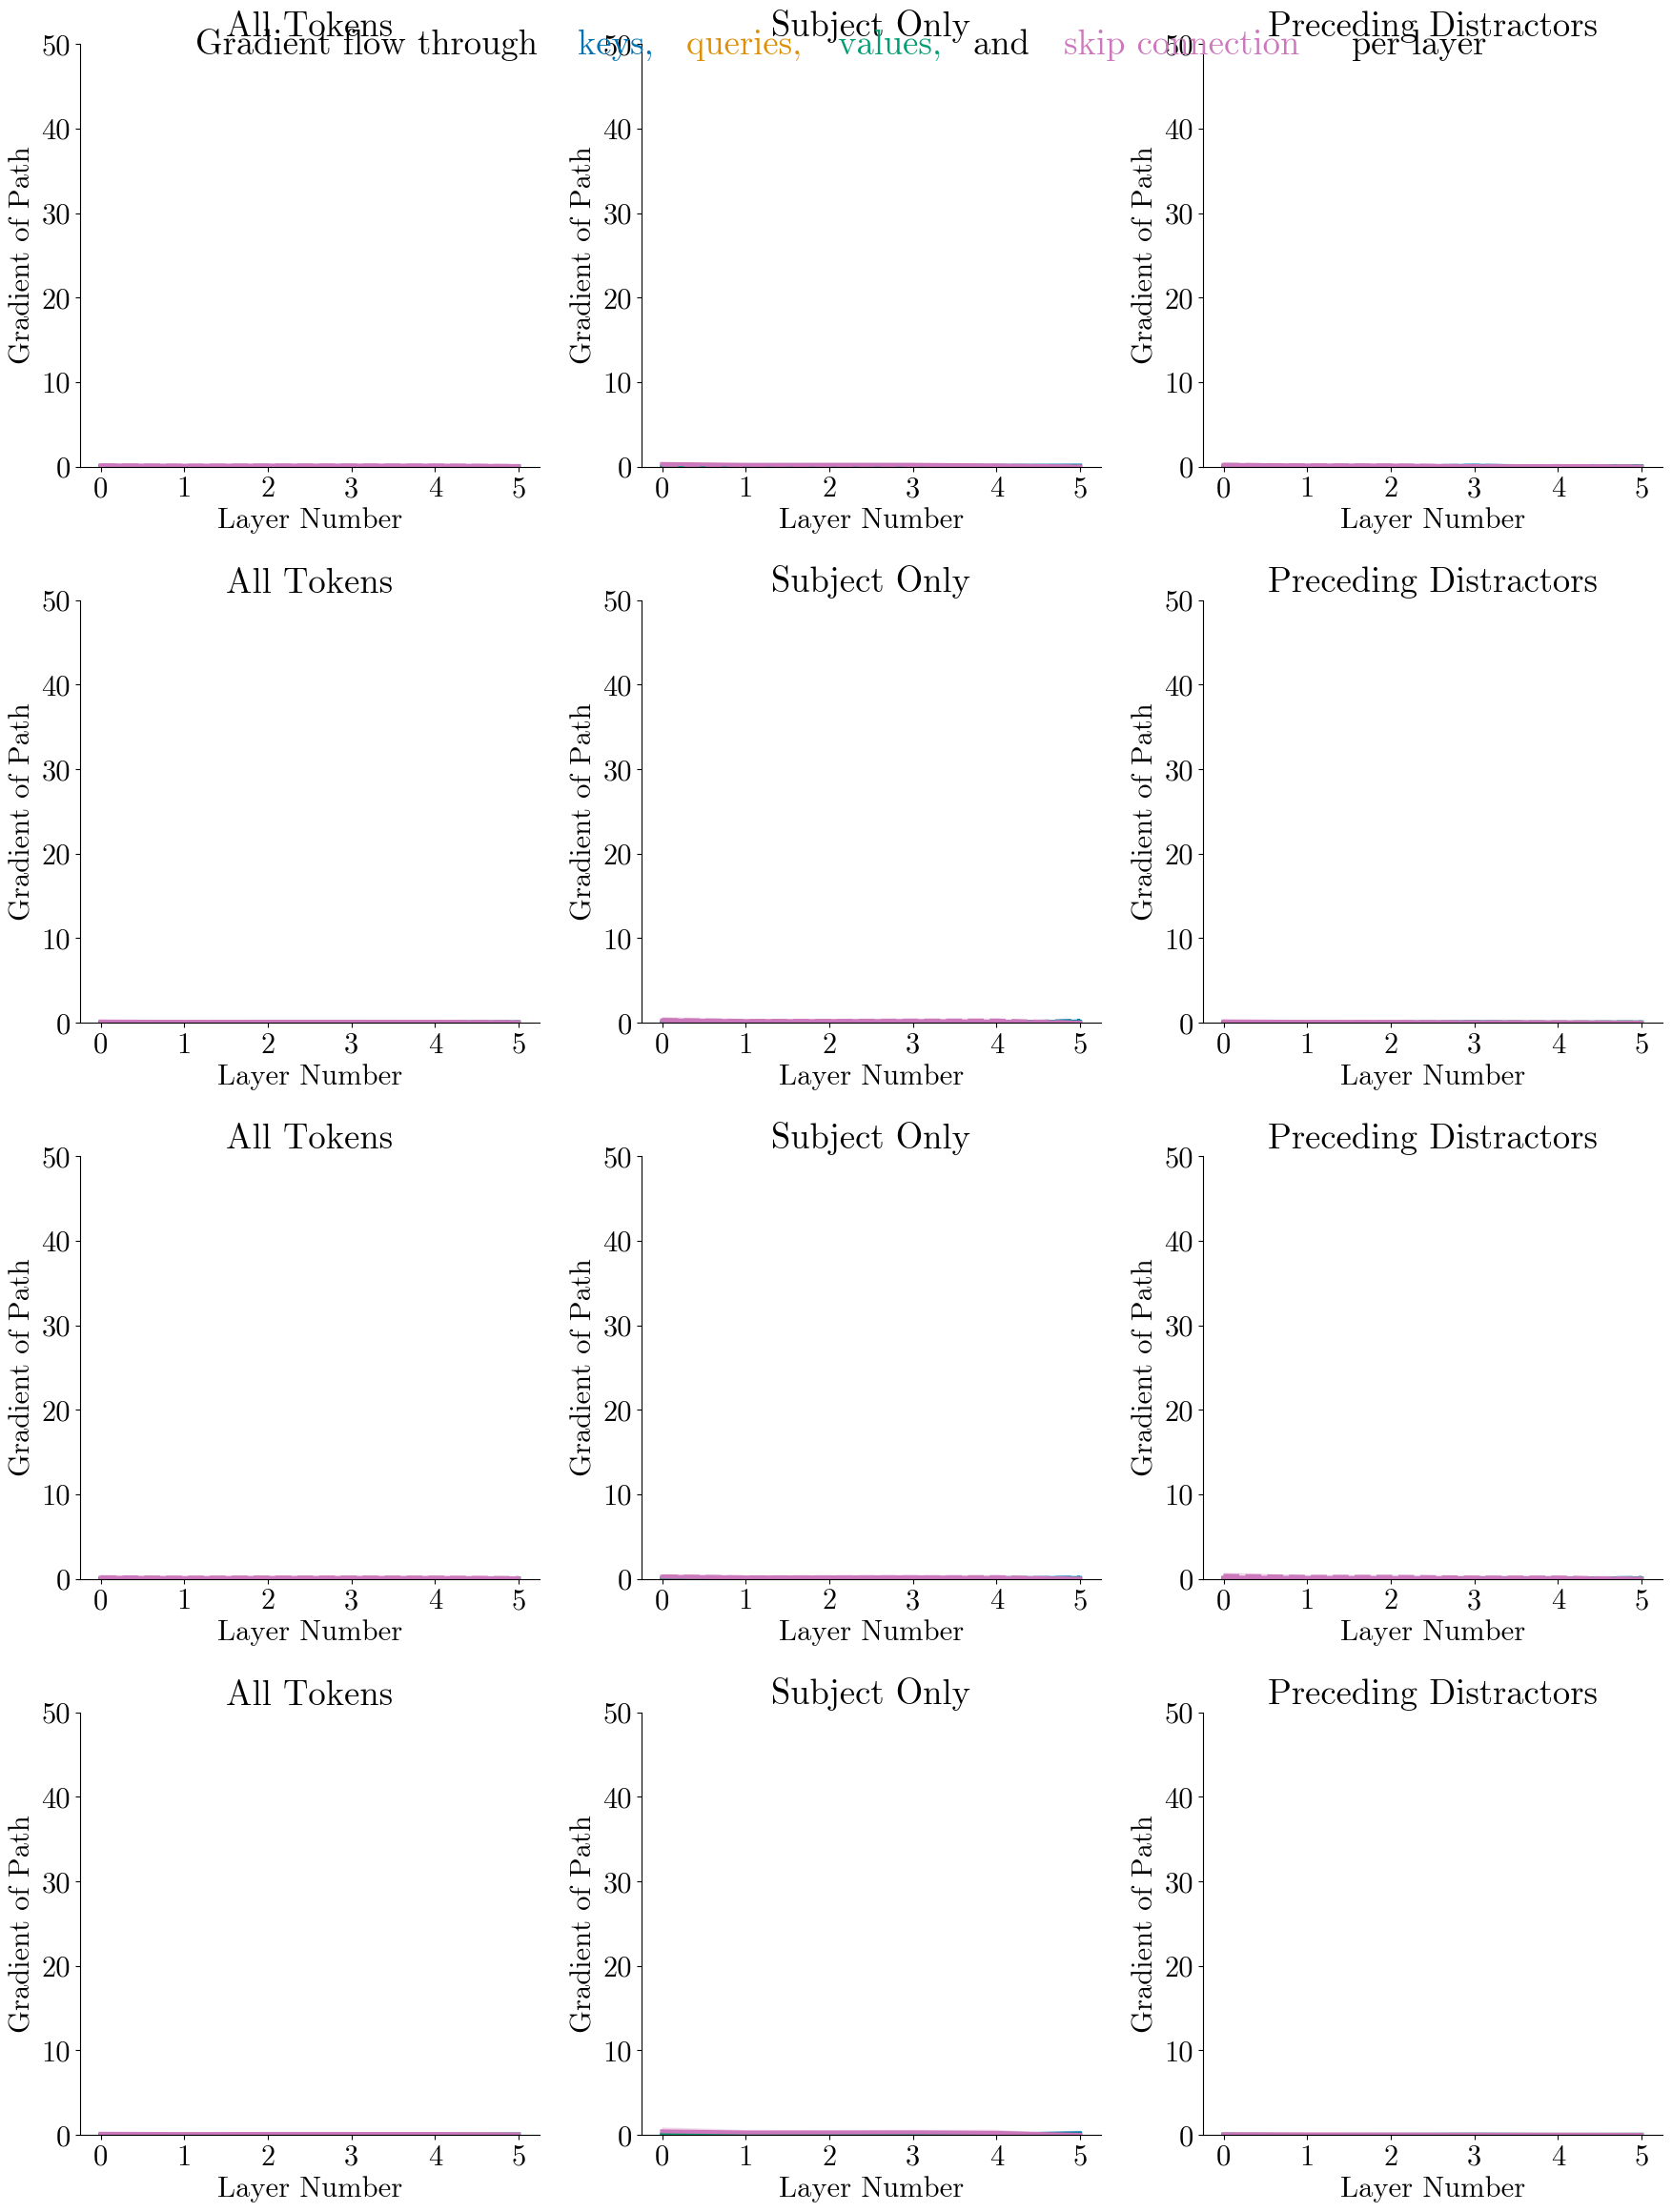

In [33]:
dfs = [df, df_only_subj, df_only_distractors]
dfs_per_na = [[d[d["num_distractors"] == i] for d in dfs] for i in range(1, 5)]
titles = ["All Tokens", "Subject Only", "Preceding Distractors"]
ncols = 3
nrows = 4 # int(np.ceil(len(dfs) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 24))
# plt.tight_layout()
for i in range(len(dfs_per_na)):
    for j in range(len(dfs_per_na[i])):
        use_legend = False # (i == len(dfs) - 1)
        row, col = i, j
        ax = axes[row, col] if nrows > 1 else axes[col]
        sns.lineplot(
            data=dfs_per_na[i][j], 
            x="layer_num", 
            y="path grad", 
            hue="path_name", 
            style="is_correct",
            style_order=[True, False],
            ax=ax,
            legend=use_legend,
            linewidth=3,
        )
        ax.set_ylim((0, 50))
        ax.set_title(titles[j], wrap=True)
        ax.set_xlabel("Layer Number")
        ax.set_ylabel("Gradient of Path")
        ax.set_xticks(ticks=sorted(dfs_per_na[i][j]["layer_num"].unique()))
linecolors = [l.get_color() for l in ax.get_lines()]
print(linecolors)
# Lolmao you can't make a title have different colors in it so...manual labor it is l o l.
offset = 0.23
fig.text(0. + offset, 0.95, "Gradient flow through ", ha="center", va="bottom", size="large", color="black")
fig.text(0.145 + offset, 0.95, "keys, ", ha="center", va="bottom", size="large", color=linecolors[0])
fig.text(0.22 + offset, 0.95, "queries, ", ha="center", va="bottom", size="large", color=linecolors[1])
fig.text(0.305 + offset, 0.95, "values, ", ha="center", va="bottom", size="large", color=linecolors[2])
fig.text(0.37 + offset, 0.95, "and ", ha="center", va="bottom", size="large", color="black")
fig.text(0.475 + offset, 0.95, "skip connection ", ha="center", va="bottom", size="large", color=linecolors[3])
fig.text(0.61 + offset, 0.95, "per layer", ha="center", va="bottom", size="large", color="black")
# fig.text(0.24 + offset, 0.60, "GOOD BERT", ha="center", va="bottom", size="large", color="red")

# fig.suptitle("Gradient flow through keys, values, queries, and skip connection per layer", wrap=True)
fig.suptitle("")

# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc="right")
# ax.get_legend().remove()
plt.tight_layout()
save_path = os.path.join(PLOTS_DIR, "max_grad_kvqskip_tokens_subj_and_preceding_distractors_per_na.png")
save_path_pdf = os.path.join(PLOTS_DIR, "max_grad_kvqskip_tokens_subj_and_preceding_distractors_per_na.pdf")
plt.savefig(save_path, bbox_inches="tight")
plt.savefig(save_path_pdf, bbox_inches="tight")
wandb.log({"plot_max_grad_kvqskip_tokens_subj_and_preceding_distractors_per_na": wandb.Image(save_path)})

In [34]:
wandb.finish()

### Error Analysis using this method

In [35]:
df_correct_and_distractors = df.groupby("sentence_index")["is_correct", "num_distractors"].agg("mean")
df_correct_and_distractors[df_correct_and_distractors["is_correct"] == 1.0]
count_distractors = df_correct_and_distractors.groupby("num_distractors")["is_correct"].agg("count")
count_distractors.name = "count"

percent_correct_per_distractors = df_correct_and_distractors[df_correct_and_distractors["is_correct"] == 1.0]["num_distractors"].value_counts() / count_distractors
percent_correct_per_distractors.name = "% correct"

pd.concat([count_distractors, percent_correct_per_distractors], axis=1)


/tmp/ipykernel_203722/1278909623.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_correct_and_distractors = df.groupby("sentence_index")["is_correct", "num_distractors"].agg("mean")


,count,% correct
1.0,829,0.957780
2.0,131,0.946565
3.0,33,0.939394
4.0,7,1.000000
